#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 07
**CH07A Finding a Good Deal among Hotels with Simple Regression**

hotels-vienna  dataset

version 1.0 2021-05-05

In [1]:
%pip install scikit-misc
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mizani.formatters import percent_format
from plotnine import *
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.


In [2]:
# load vienna
hotels = pd.read_csv("/workspaces/codespaces-jupyter/data/hotels-vienna.csv")
# hotels = pd.read_csv("https://osf.io/y6jvb/download")
 

### SAMPLE SELECTION

Apply filters:  3-4 stars, Vienna actual, without  extreme value

In [3]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]
hotels


,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,offer_cat,year,month,weekend,holiday,distance,distance_alter,accommodation_type,nnights,rating
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1-15% offer,2017,11,0,0,1.7,3.8,Hotel,1,3.9
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.4,2.5,Hotel,1,3.7
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,15-50% offer,2017,11,0,0,1.7,2.5,Hotel,1,4.0
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,15-50% offer,2017,11,0,0,1.2,2.8,Hotel,1,3.9
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0% no offer,2017,11,0,0,0.9,2.4,Hotel,1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1-15% offer,2017,11,0,0,1.2,3.7,Hotel,1,4.0
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1-15% offer,2017,11,0,0,1.5,3.9,Hotel,1,4.1
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1-15% offer,2017,11,0,0,1.5,4.0,Hotel,1,3.4
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,0% no offer,2017,11,0,0,1.0,3.7,Hotel,1,4.4


In [4]:
# save a copy of the work file
hotels.to_csv("hotels_work_copy.csv", index=False)


### Summary statistics on price and distance

In [5]:
# Price
hotels[["price"]].describe(percentiles=[0.50, 0.95])


,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


In [6]:
# Distance
hotels[["distance"]].describe(percentiles=[0.50, 0.95])


,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
50%,1.300000
95%,3.900000
max,6.600000


In [7]:
hotels[["distance"]].describe()

,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
25%,0.800000
50%,1.300000
75%,1.900000
max,6.600000


### REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE


In [8]:
hotels["dist2"] = hotels["distance"] >= 2
hotels["Eprice_cat2"] = hotels.groupby("dist2")["price"].transform("mean")
hotels["Eprice_cat2"].unique()

array([116.42675159,  89.72      ])

In [9]:
hotels["dist2"] = hotels["dist2"].replace(False, "Close")
hotels["dist2"] = hotels["dist2"].replace(True, "Far")

In [10]:
hotels[["dist2", "distance", "price"]].groupby("dist2").aggregate("describe")

distance                                               price  \
         count      mean       std  min  25%  50%  75%  max  count   
dist2                                                                
Close    157.0  0.994904  0.539325  0.0  0.5  0.9  1.5  1.9  157.0   
Far       50.0  3.210000  0.973789  2.0  2.4  3.1  3.7  6.6   50.0   

                                                                
             mean        std   min    25%    50%    75%    max  
dist2                                                           
Close  116.426752  43.095928  54.0  85.00  109.0  135.0  383.0  
Far     89.720000  32.085371  50.0  74.25   81.5   96.5  208.0

# Figure 7.1a
# PLOT MEAN VALUES BY CLOSE VS FAR

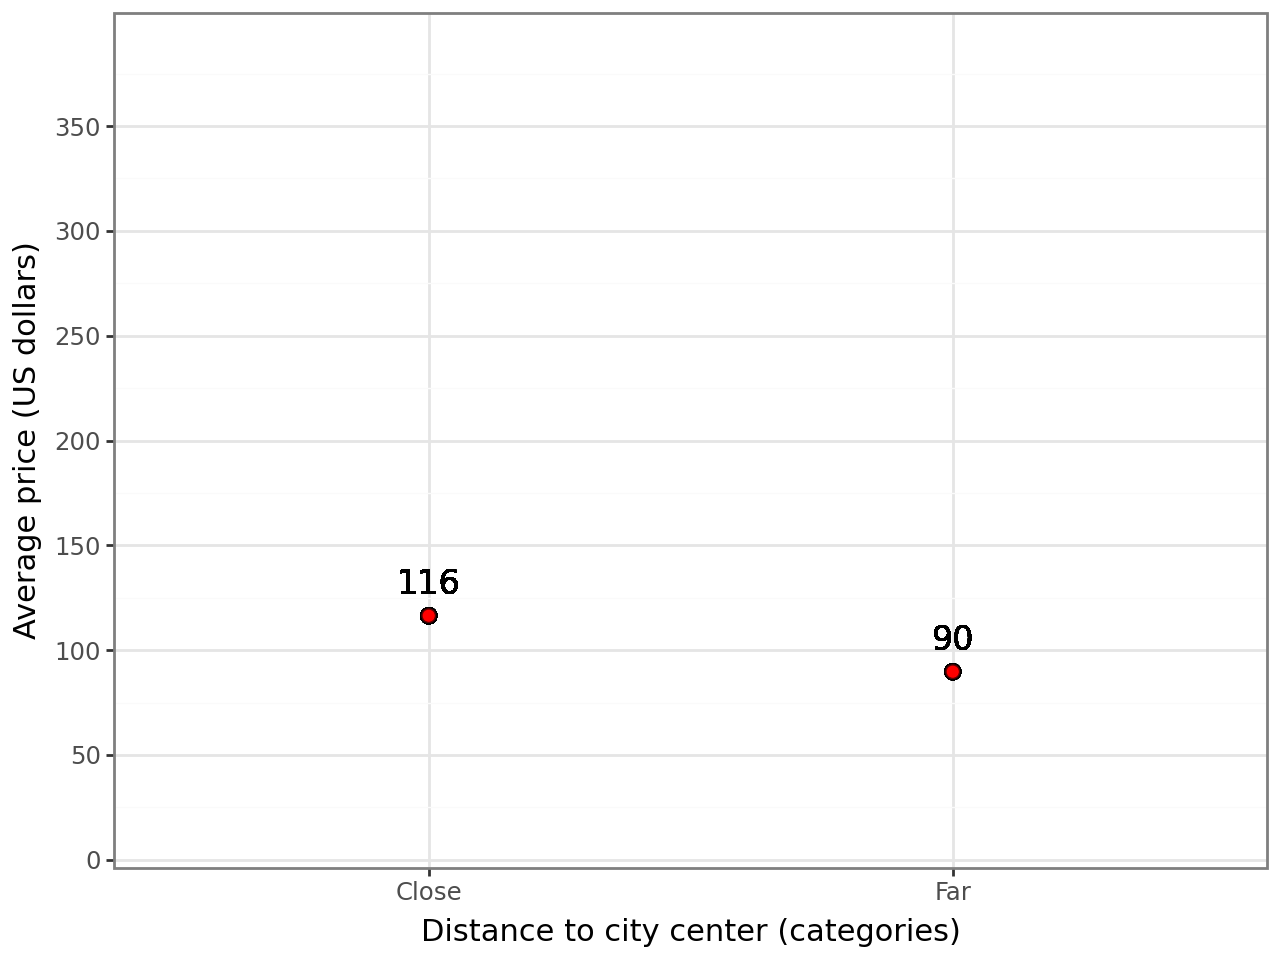

In [11]:
(
    ggplot(hotels)
    + geom_point(
        aes(x="dist2", y="Eprice_cat2"),
        size=2.5,
        color="black",
        fill="red",
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="dist2",
            y="[x+15 for x in Eprice_cat2]",
            label=np.round(hotels.Eprice_cat2).apply(int),
        ),
        color="black",
        size=12,
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + expand_limits(y=0.01)
    + scale_x_discrete()
    + labs(x="Distance to city center (categories)", y="Average price (US dollars)")
    + theme_bw()
)


In [12]:
hotels["dist4"] = hotels["distance"].apply(
    lambda x: 0.5 + 1 * int(x >= 1) + 1 * int(x >= 2) + 2.5 * int(x >= 3)
)
hotels["dist4"].unique

<bound method Series.unique of 1      1.5
2      1.5
3      1.5
4      1.5
6      0.5
      ... 
420    1.5
421    1.5
422    1.5
425    1.5
426    1.5
Name: dist4, Length: 207, dtype: float64>

In [13]:
hotels["Eprice_cat4"] = hotels.groupby("dist4")["price"].transform("mean")

In [14]:
hotels[["dist4", "distance", "price"]].groupby("dist4").aggregate("describe")


distance                                                price  \
         count      mean       std  min    25%  50%  75%  max count   
dist4                                                                 
0.5       81.0  0.554321  0.282865  0.0  0.300  0.6  0.8  0.9  81.0   
1.5       76.0  1.464474  0.294258  1.0  1.200  1.5  1.7  1.9  76.0   
2.5       22.0  2.354545  0.318818  2.0  2.100  2.3  2.6  2.9  22.0   
5.0       28.0  3.882143  0.759656  3.0  3.475  3.7  4.1  6.6  28.0   

                                                                  
             mean        std   min     25%    50%     75%    max  
dist4                                                             
0.5    132.913580  38.540627  68.0  110.00  128.0  152.00  242.0  
1.5     98.855263  40.893261  54.0   81.75   91.5  105.25  383.0  
2.5     97.545455  40.385909  54.0   76.25   82.5  100.75  208.0  
5.0     83.571429  22.596998  50.0   68.75   79.0   91.25  156.0

In [15]:
a=hotels["dist4"].unique()
for d in a:
    mean_price = hotels.loc[hotels["dist4"] == d, "Eprice_cat4"].iloc[0]
    print(f"dist4 = {d}: Eprice_cat4 = {mean_price}")


dist4 = 1.5: Eprice_cat4 = 98.85526315789474
dist4 = 0.5: Eprice_cat4 = 132.91358024691357
dist4 = 5.0: Eprice_cat4 = 83.57142857142857
dist4 = 2.5: Eprice_cat4 = 97.54545454545455


In [16]:
import pandas as pd

# Assume you already have your hotels DataFrame with a 'distance' and 'price' column

# Step 1: Define bins and assign them
bins = [0, 1, 2, 3, float('inf')]
labels = ['bin1', 'bin2', 'bin3', 'bin4']
hotels['bin'] = pd.cut(hotels['distance'], bins=bins, labels=labels, right=False)

# Step 2: Define the midpoints of each bin
bin_midpoints = {
    'bin1': 0.5,
    'bin2': 1.5,
    'bin3': 2.5,
    'bin4': 5.0  # authors used 5.0 as midpoint for the last wider bin
}

# Step 3: Compute average price in each bin
avg_prices = hotels.groupby('bin')['price'].mean()
avg_prices = avg_prices.reindex(labels)  # keep bin order

# Step 4: Compute slopes between adjacent bins
slopes = []
slope_sum = 0
n = 0
#weights = []
slope_weighted_sum = 0
weight_sum = 0

for i in range(len(labels) - 1):
    bin_a = labels[i]
    bin_b = labels[i + 1]
    
    x1 = bin_midpoints[bin_a]
    x2 = bin_midpoints[bin_b]
    
    y1 = avg_prices[bin_a]
    y2 = avg_prices[bin_b]
    
    slope = round((y2 - y1) / (x2 - x1), 0)
    slopes.append(slope)
    slope_sum += slope 
    n += 1
    width = slope / slope_sum  # this is the weight: slope divided by total of all slopes
    slope_weighted_sum += slope * width
    weight_sum += width

# Output

w=0
s=0
sum_w=0

for i, slope in enumerate(slopes):
    
    print(f"Slope between {labels[i]} and {labels[i+1]}: {slope}")
    
    w = float(slope/slope_sum)
    print(f"Weight:{w}")
    sum_w += w
    
    a=slope*w
    print(f"Up:{a}")
    
    print()
    s += a
   # print(width)
    u =round(slope_sum / n, 0)
    w =round(slope_weighted_sum / weight_sum, 0)


print(f"Unweighted Avg:{round(slope_sum/n,0)}")
print(s)
print(sum_w)
print(f"Weighted Avg:{round(s/sum_w,0)}")

#print(w)
#print(slope_weighted_sum)
#print(weight_sum)


Slope between bin1 and bin2: -34.0
Weight:0.8292682926829268
Up:-28.195121951219512

Slope between bin2 and bin3: -1.0
Weight:0.024390243902439025
Up:-0.024390243902439025

Slope between bin3 and bin4: -6.0
Weight:0.14634146341463414
Up:-0.8780487804878048

Unweighted Avg:-14.0
-29.097560975609756
1.0
Weighted Avg:-29.0


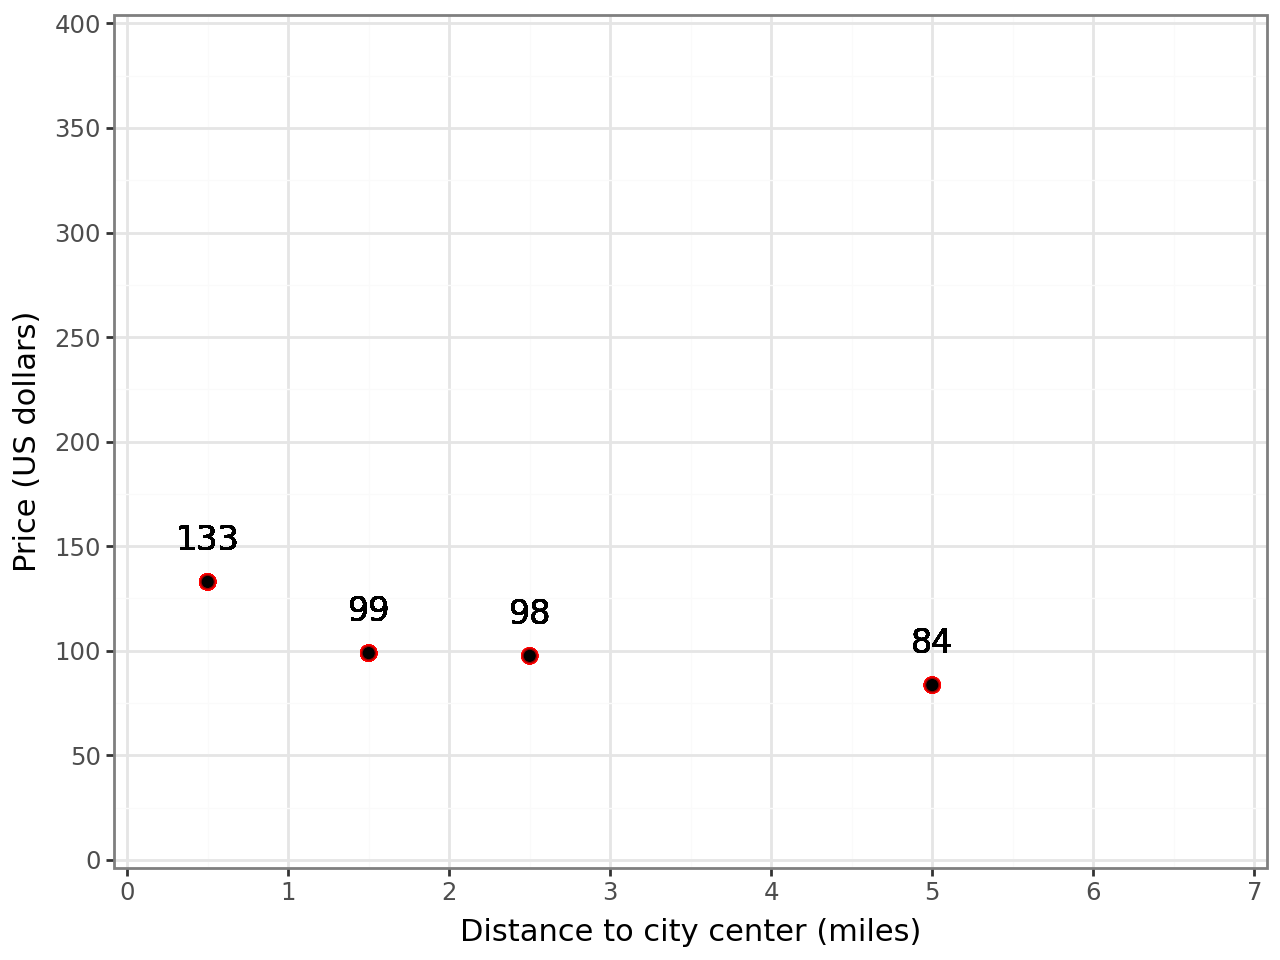

In [17]:
(
    ggplot(data=hotels)
    + geom_point(
        aes(x="dist4", y="Eprice_cat4"),
        size=2.5,
        color="red",
        fill="black",
        alpha=0.4,
    )
    + geom_text(
        aes(
            x="dist4",
            y="[x+20 for x in Eprice_cat4]",
            label=np.round(hotels.Eprice_cat4).apply(int),
        ),
        color="black",
        size=12,
    )
    + expand_limits(x=0.01, y=0.01)
    + coord_cartesian(xlim=[0, 7], ylim=[0, 400])
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 401, 50))
    + scale_x_continuous(
        expand=[0.01, 0.01], limits=[0, 7], breaks=[0, 1, 2, 3, 4, 5, 6, 7]
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)


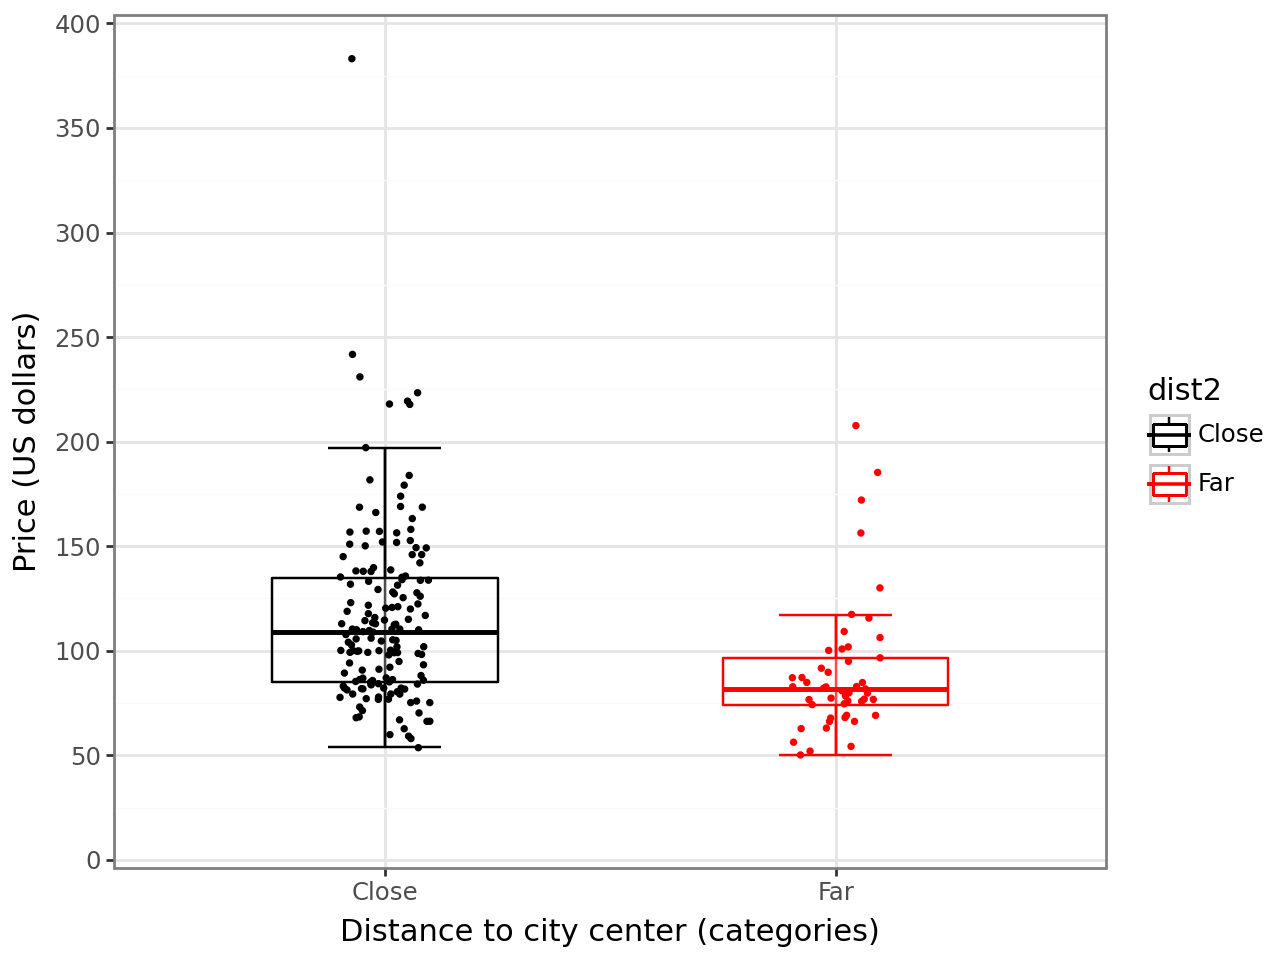

In [18]:
(
    ggplot(hotels, aes(x="dist2", y="price"))
    + stat_boxplot(
        aes(group="dist2", color="dist2"), geom="errorbar", width=0.25, size=0.5
    )
    + geom_boxplot(
        aes(group="dist2", color="dist2"),
        size=0.5,
        width=0.5,
        alpha=0.3,
        outlier_color="",  # to hide outliers
    )
    + geom_jitter(
        aes(color="dist2"), position=position_jitter(0.1), size=0.5, show_legend=False
    )
    + scale_color_manual(values=["black", "red"])
    + labs(x="Distance to city center (categories)", y="Price (US dollars)")
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 401, 50))
    + expand_limits(y=0.01)
    + theme_bw()
)


## FIGURE 7.2a 7.2b

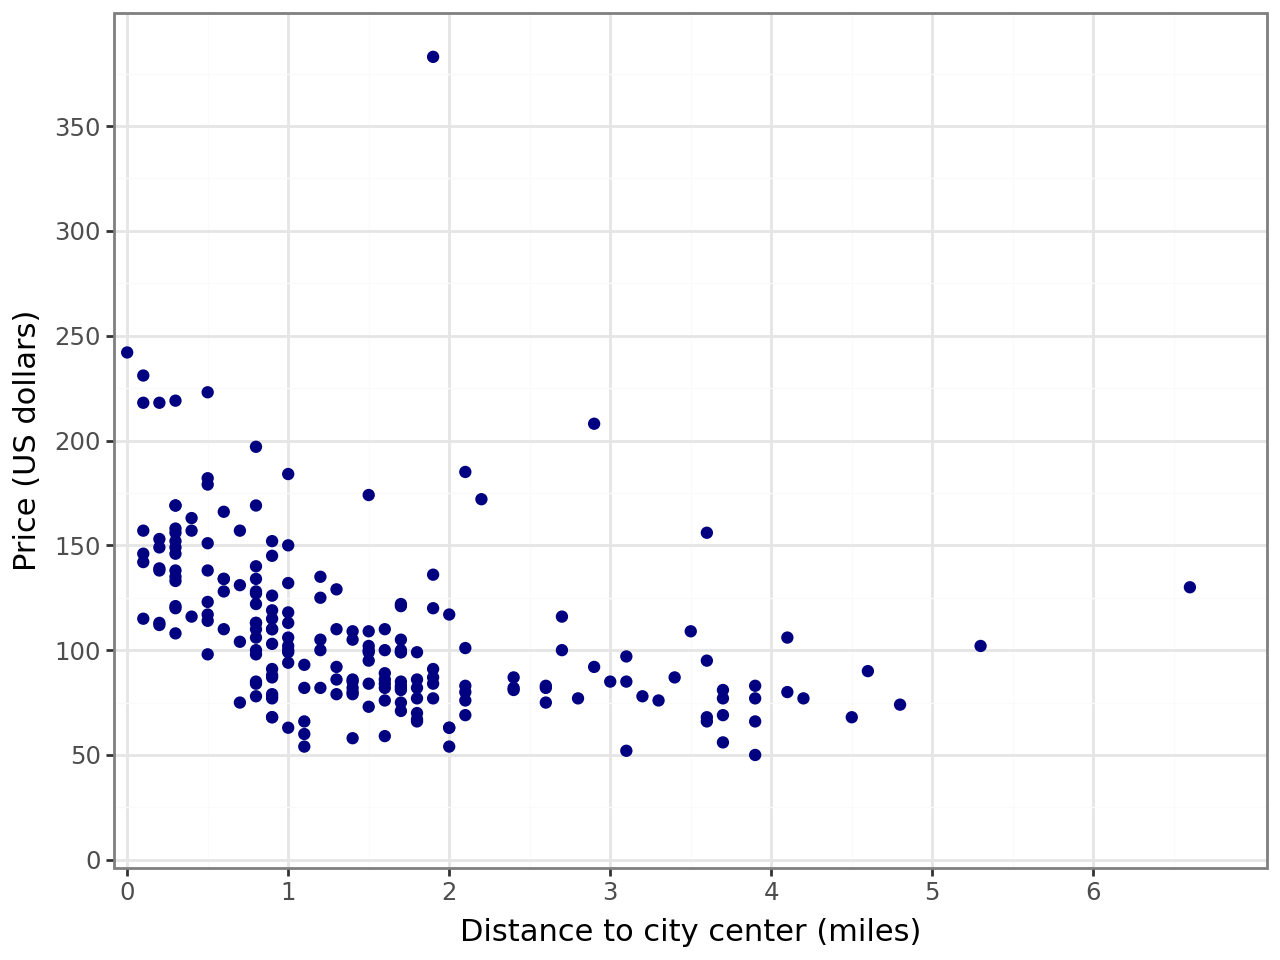

In [19]:
p1 = (
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color="navy")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=np.arange(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)
p1.show()

In [20]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,distance,distance_alter,accommodation_type,nnights,rating,dist2,Eprice_cat2,dist4,Eprice_cat4,bin
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1.7,3.8,Hotel,1,3.9,Close,116.426752,1.5,98.855263,bin2
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1.4,2.5,Hotel,1,3.7,Close,116.426752,1.5,98.855263,bin2
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1.7,2.5,Hotel,1,4.0,Close,116.426752,1.5,98.855263,bin2
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1.2,2.8,Hotel,1,3.9,Close,116.426752,1.5,98.855263,bin2
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0.9,2.4,Hotel,1,3.9,Close,116.426752,0.5,132.913580,bin1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1.2,3.7,Hotel,1,4.0,Close,116.426752,1.5,98.855263,bin2
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1.5,3.9,Hotel,1,4.1,Close,116.426752,1.5,98.855263,bin2
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1.5,4.0,Hotel,1,3.4,Close,116.426752,1.5,98.855263,bin2
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1.0,3.7,Hotel,1,4.4,Close,116.426752,1.5,98.855263,bin2


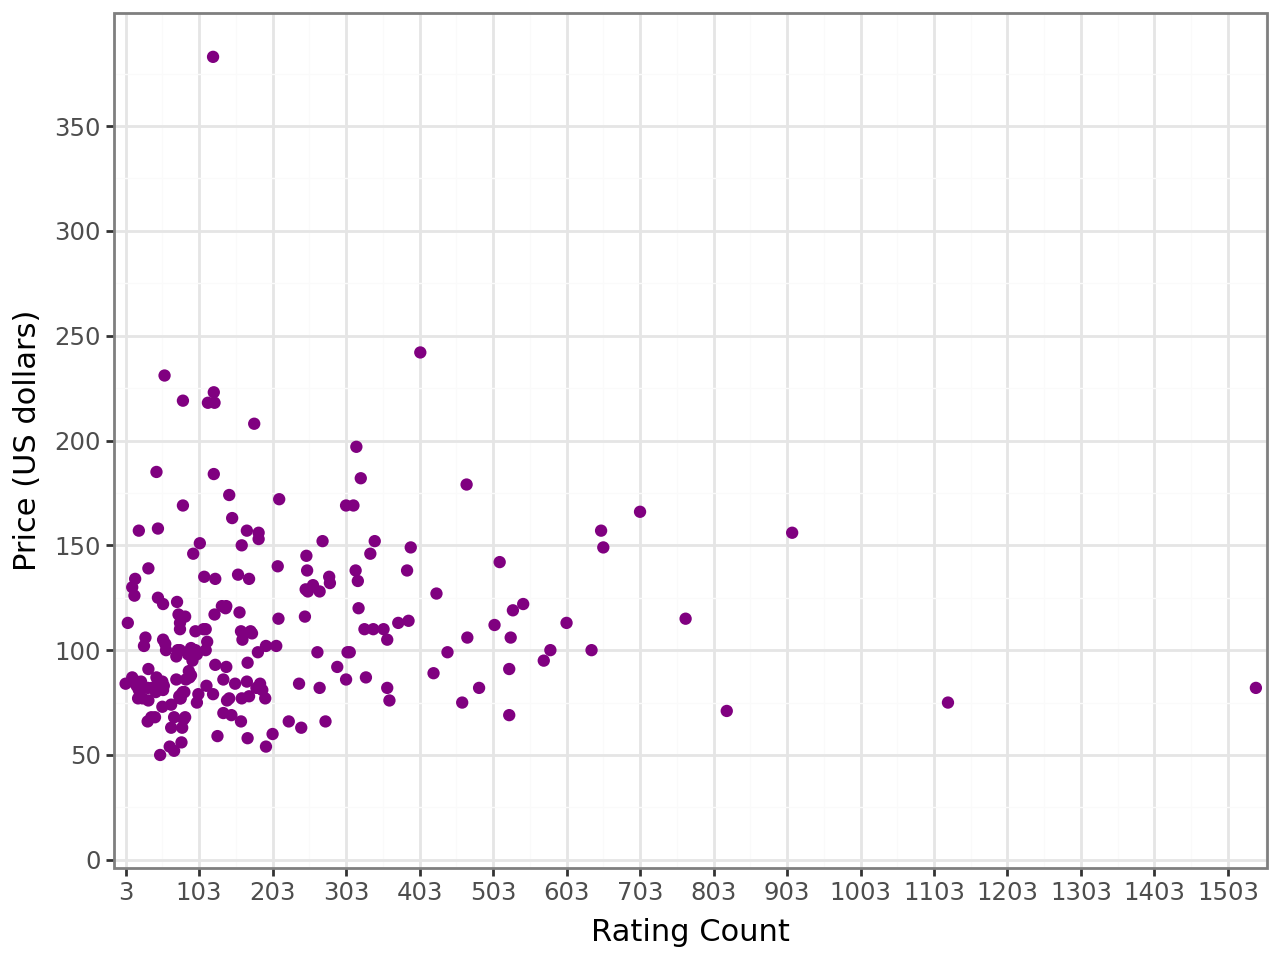

In [21]:
rat_max=hotels["rating_count"].max()
rat_min=hotels["rating_count"].min()

p3 = (
    ggplot(hotels, aes(x="rating_count", y="price"))
    + geom_point(color="purple")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[rat_min, rat_max], breaks=np.arange(rat_min, rat_max, 100))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + labs(x="Rating Count", y="Price (US dollars)")
    + theme_bw()
)
p3.show()

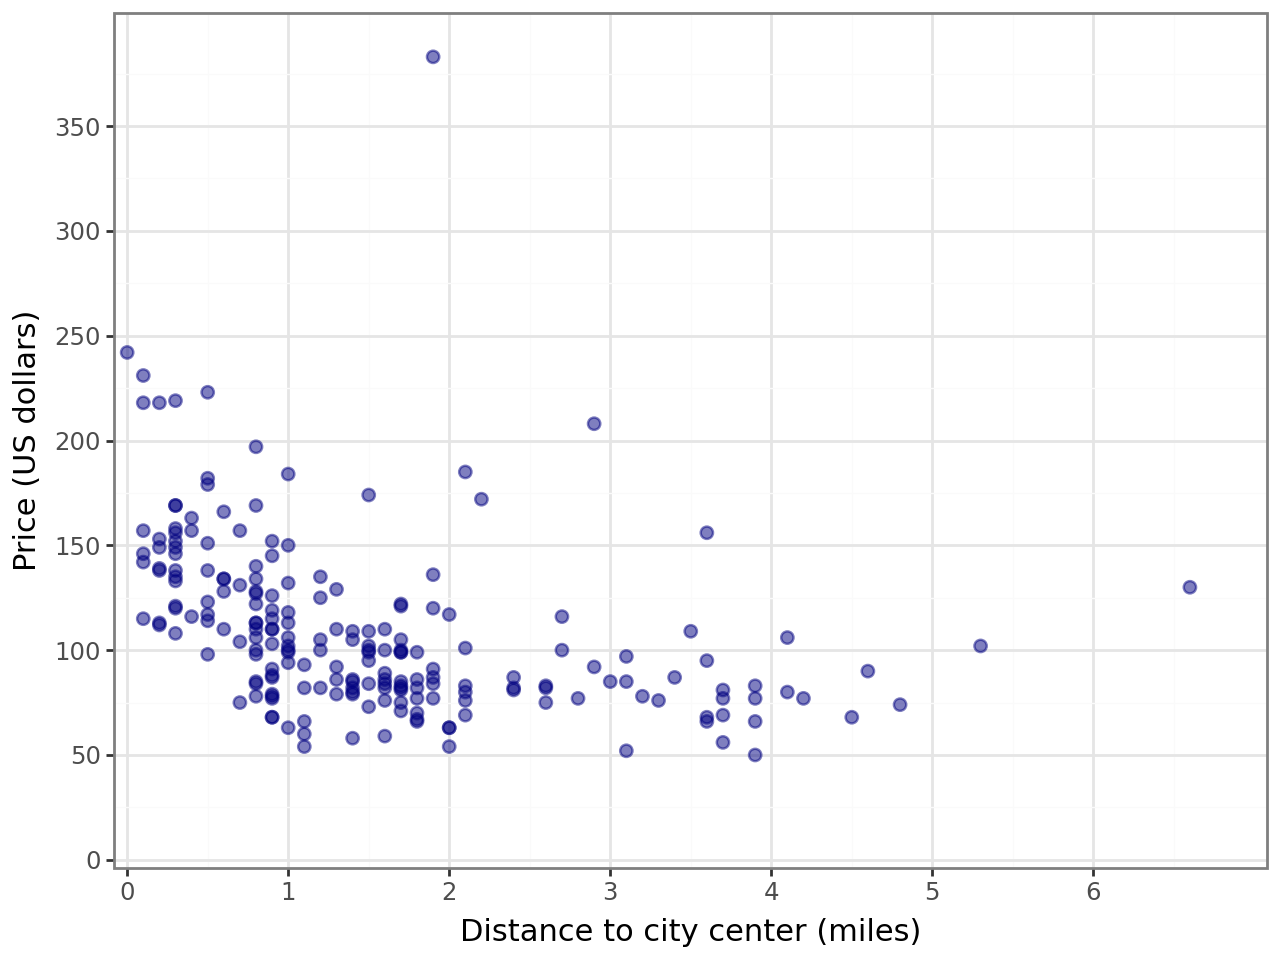

In [22]:
# large sized graphs
(
    ggplot(hotels)
    + geom_point(
        aes(x="distance", y="price"),
        color="navy",
        size=2,
        alpha=0.5,
        show_legend=False,
        na_rm=True,
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=np.arange(0, 7, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=np.arange(0, 400, 50))
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)


#### Scatterplot with step function (we use 1km bits for simpplicity using 4 bits for 3-7km)


In [23]:
hotels["dist4_s"] = hotels["distance"].apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
)
hotels["xend"] = hotels["dist4_s"] + 1
hotels["yend"] = hotels["Eprice_cat4"]


In [24]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,nnights,rating,dist2,Eprice_cat2,dist4,Eprice_cat4,bin,dist4_s,xend,yend
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1,3.9,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1,3.7,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1,4.0,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1,3.9,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,1,3.9,Close,116.426752,0.5,132.913580,bin1,0,1,132.913580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1,4.0,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1,4.1,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1,3.4,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1,4.4,Close,116.426752,1.5,98.855263,bin2,1,2,98.855263


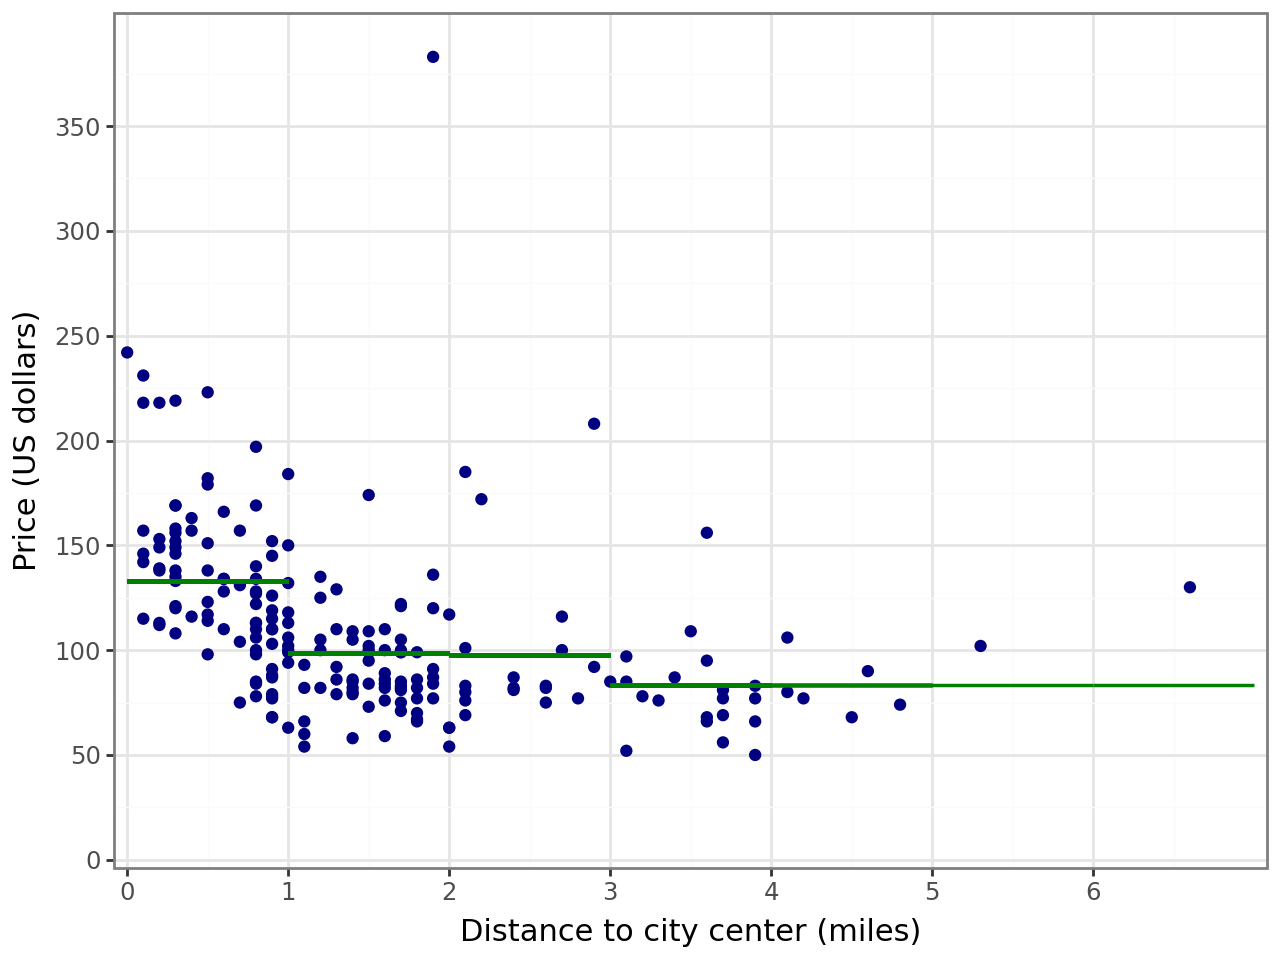

In [25]:
F07_2a = p1 + geom_segment(
    hotels,
    aes("dist4_s", "yend", xend="xend", yend="yend"),
    color="green",
    size=0.7,
    na_rm=True,
)
F07_2a.show()

In [26]:
hotels["dist7_new"] = hotels["distance"].apply(
    lambda x: 0.5
    + 1 * int(x + 1 >= 1)
    + 1 * int(x + 1 >= 2)
    + 1 * int(x + 1 >= 3)
    + 1 * int(x + 1 >= 4)
    + 1 * int(x + 1 >= 5)
    + 1 * int(x + 1 >= 6)
    + 1 * int(x + 1 >= 7)
)

In [27]:
hotels["Eprice_cat7_new"] = hotels.groupby("dist7_new")["price"].transform("mean")

In [28]:
hotels[["dist7_new", "distance", "price"]].groupby("dist7_new").aggregate("describe")


distance                                                   price  \
             count      mean       std  min    25%   50%    75%  max count   
dist7_new                                                                    
1.5           81.0  0.554321  0.282865  0.0  0.300  0.60  0.800  0.9  81.0   
2.5           76.0  1.464474  0.294258  1.0  1.200  1.50  1.700  1.9  76.0   
3.5           22.0  2.354545  0.318818  2.0  2.100  2.30  2.600  2.9  22.0   
4.5           20.0  3.525000  0.298901  3.0  3.275  3.60  3.700  3.9  20.0   
5.5            6.0  4.383333  0.292689  4.1  4.125  4.35  4.575  4.8   6.0   
6.5            1.0  5.300000       NaN  5.3  5.300  5.30  5.300  5.3   1.0   
7.5            1.0  6.600000       NaN  6.6  6.600  6.60  6.600  6.6   1.0   

                                                                       
                 mean        std    min     25%    50%     75%    max  
dist7_new                                                              
1.5        132.913580  38.540627   68.0  110.00  128.0  152.00  242.0  
2.5         98.855263  40.893261   54.0   81.75   91.5  105.25  383.0  
3.5         97.545455  40.385909   54.0   76.25   82.5  100.75  208.0  
4.5         80.650000  23.154572   50.0   67.50   77.5   85.50  156.0  
5.5         82.500000  13.619838   68.0   74.75   78.5   87.50  106.0  
6.5        102.000000        NaN  102.0  102.00  102.0  102.00  102.0  
7.5        130.000000        NaN  130.0  130.00  130.0  130.00  130.0

In [29]:
# Scatterplot with step function, starting point is simply at cut-off
hotels["dist7_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
    + 1 * int(x >= 7)
)
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]


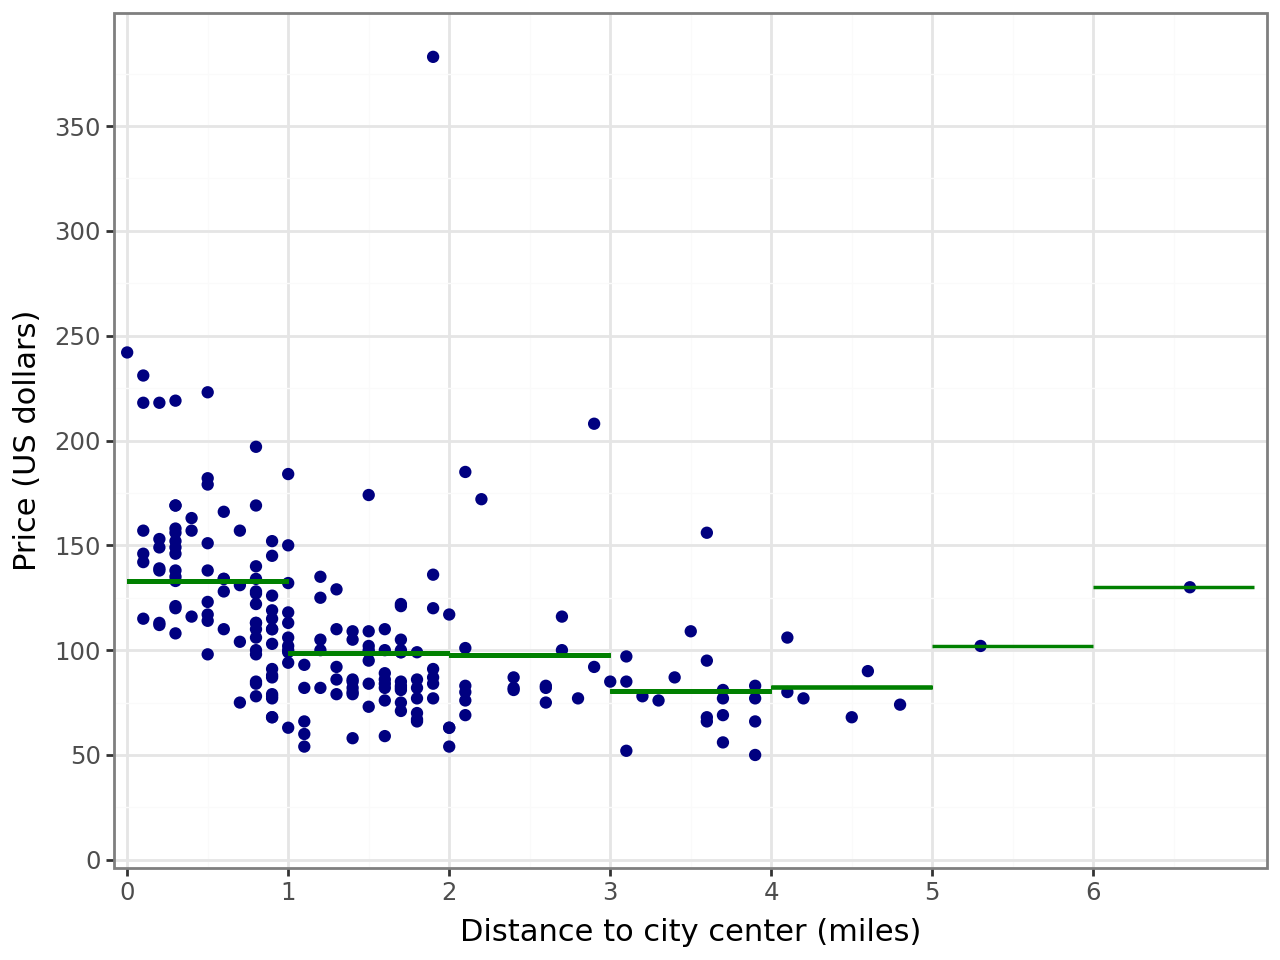

In [30]:
F07_2b = p1 + geom_segment(
    hotels,
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color="green",
    size=0.7,
    na_rm=True,
)
F07_2b.show()


# Figure 7.3
### LOWESS NONPARAMETRIC REGRESSION

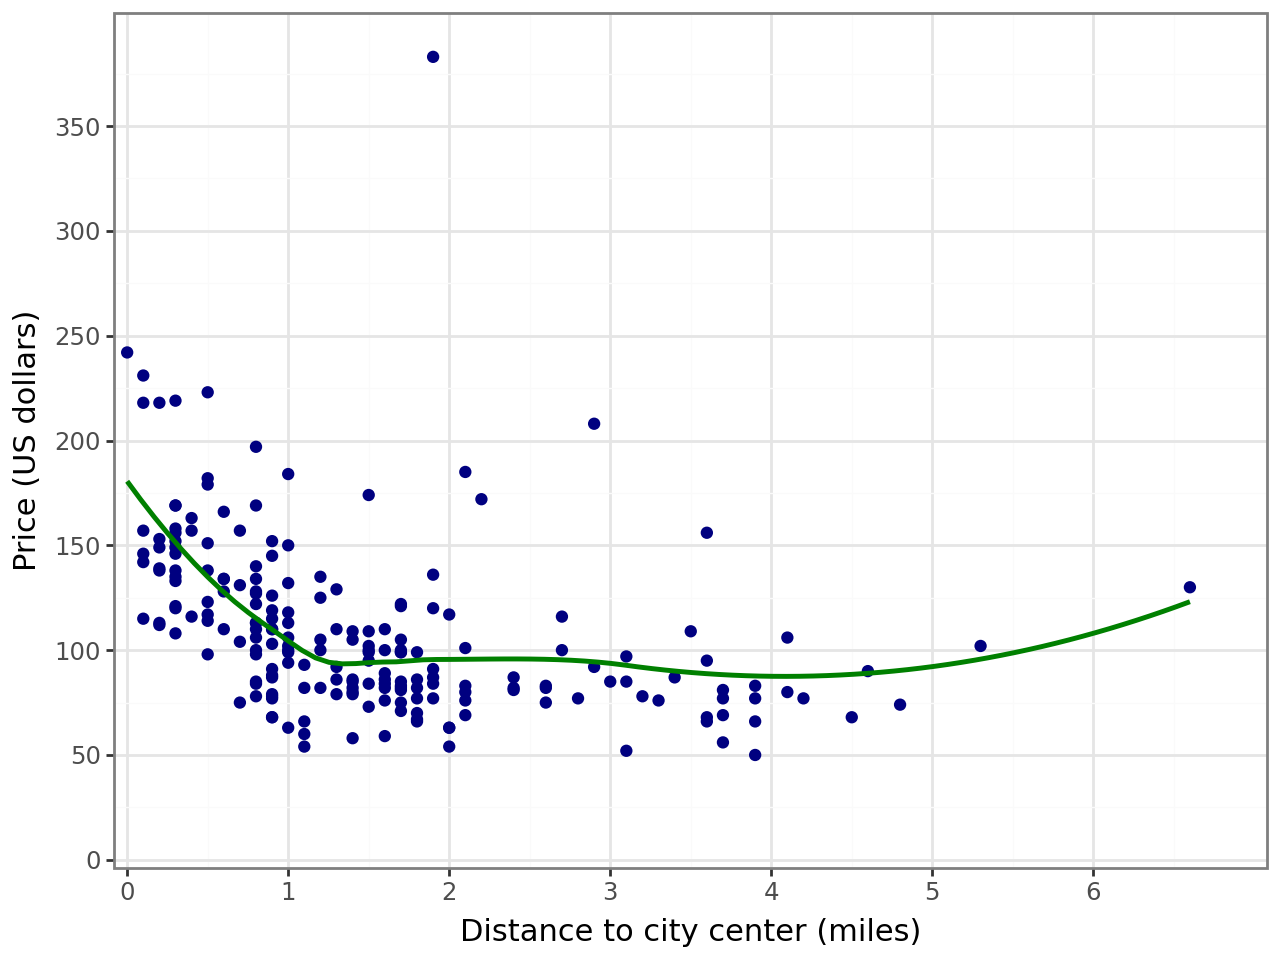

In [31]:
F07_3 = p1 + geom_smooth(method="loess", color="green", se=False)
F07_3.show()


In [32]:
### LINEAR REGRESSIONS
regression = smf.ols(formula="price~distance", data=hotels).fit()
regression.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           3.39e-09
Time:                        05:10:52   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
### LINEAR REGRESSIONS
regression_r = smf.ols(formula="price~rating_count", data=hotels).fit()
regression_r.summary()
# regression.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.764
Date:                Fri, 27 Jun 2025   Prob (F-statistic):              0.186
Time:                        05:10:52   Log-Likelihood:                -1067.1
No. Observations:                 207   AIC:                             2138.
Df Residuals:                     205   BIC:                             2145.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      106.0490      4.162     25.481      0.000      97.843     114.255
rating_count     0.0189      0.014      1.328      0.186      -0.009       0.047
==============================================================================
Omnibus:                      116.368   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              779.201
Skew:                           2.103   Prob(JB):                    6.29e-170
Kurtosis:                      11.524   Cond. No.                         415.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Figure 7.5
### SCATTERPLOT + REGRESSION LINE

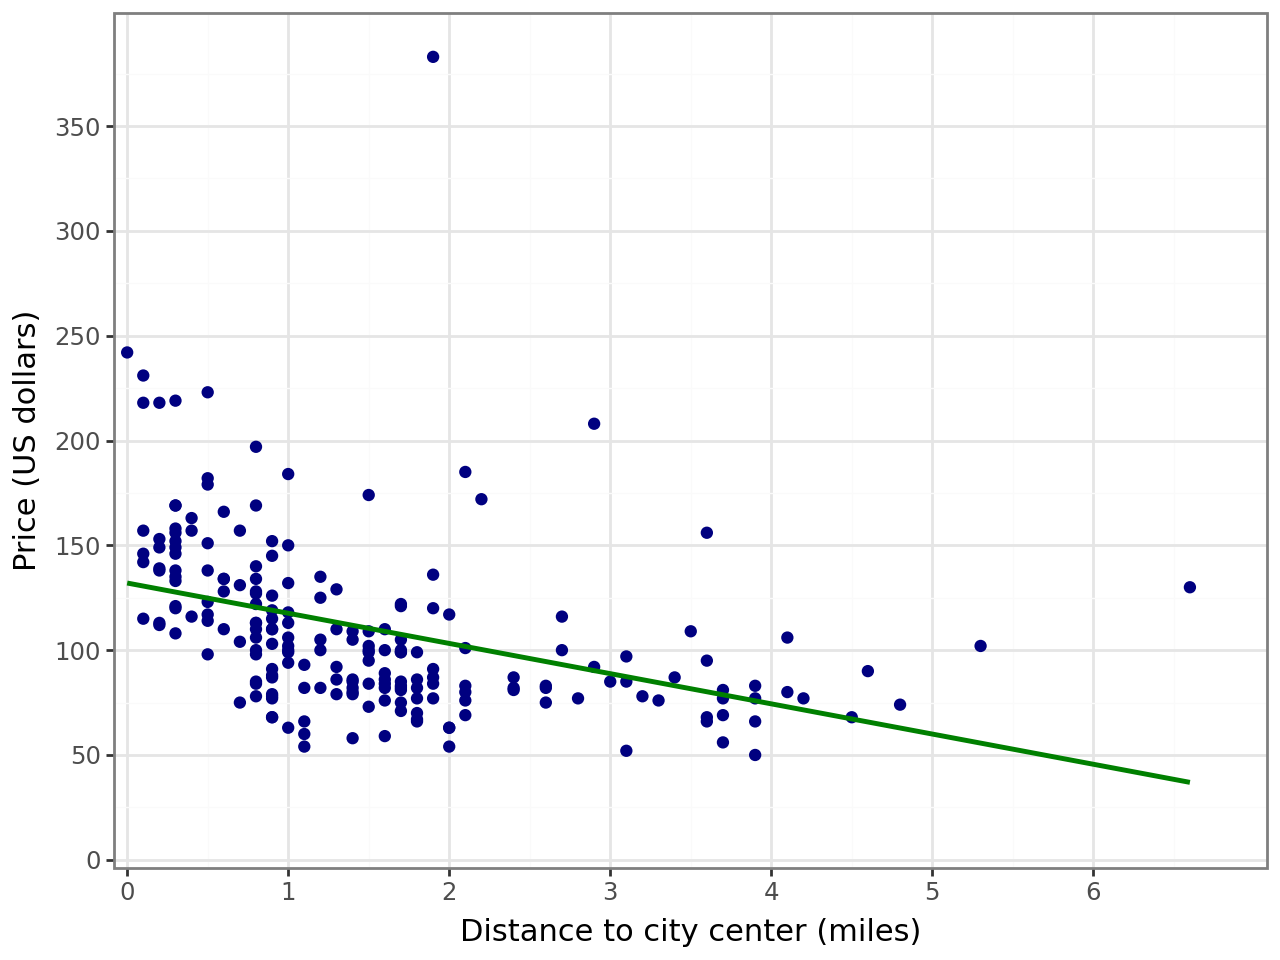

In [34]:
F07_5 = p1 + geom_smooth(method="lm", color="green", se=False)
F07_5.show()


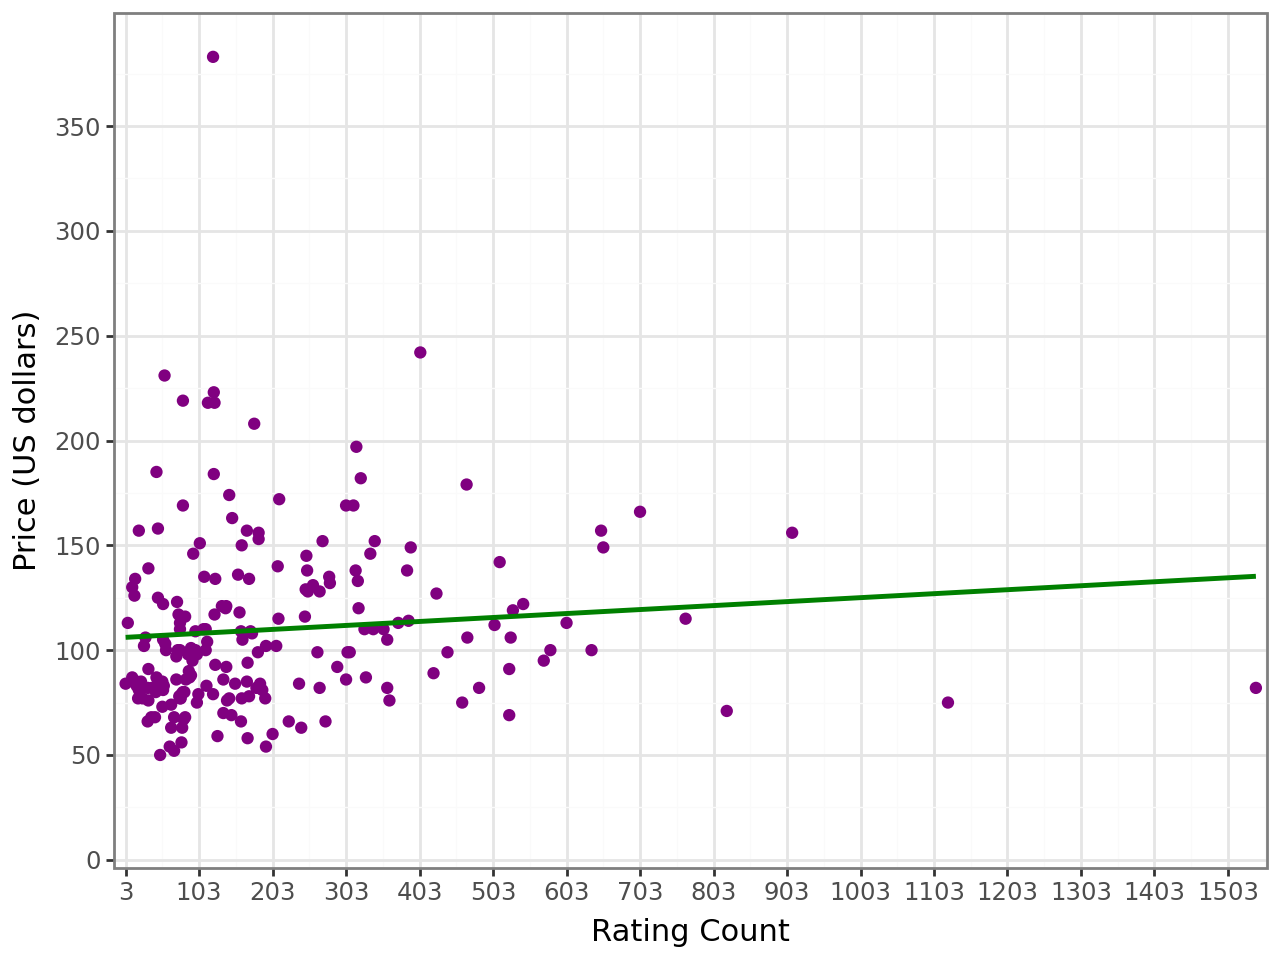

In [35]:
F07_8 = p3 + geom_smooth(method="lm", color="green", se=False)
F07_8.show()


### THE LINEAR REGRESSION GOES THROUGH THE AVERAGES
### SCATTERPLOT + REGRESSION LINE + LINES FOR AVERAGES (NOT in BOOK)

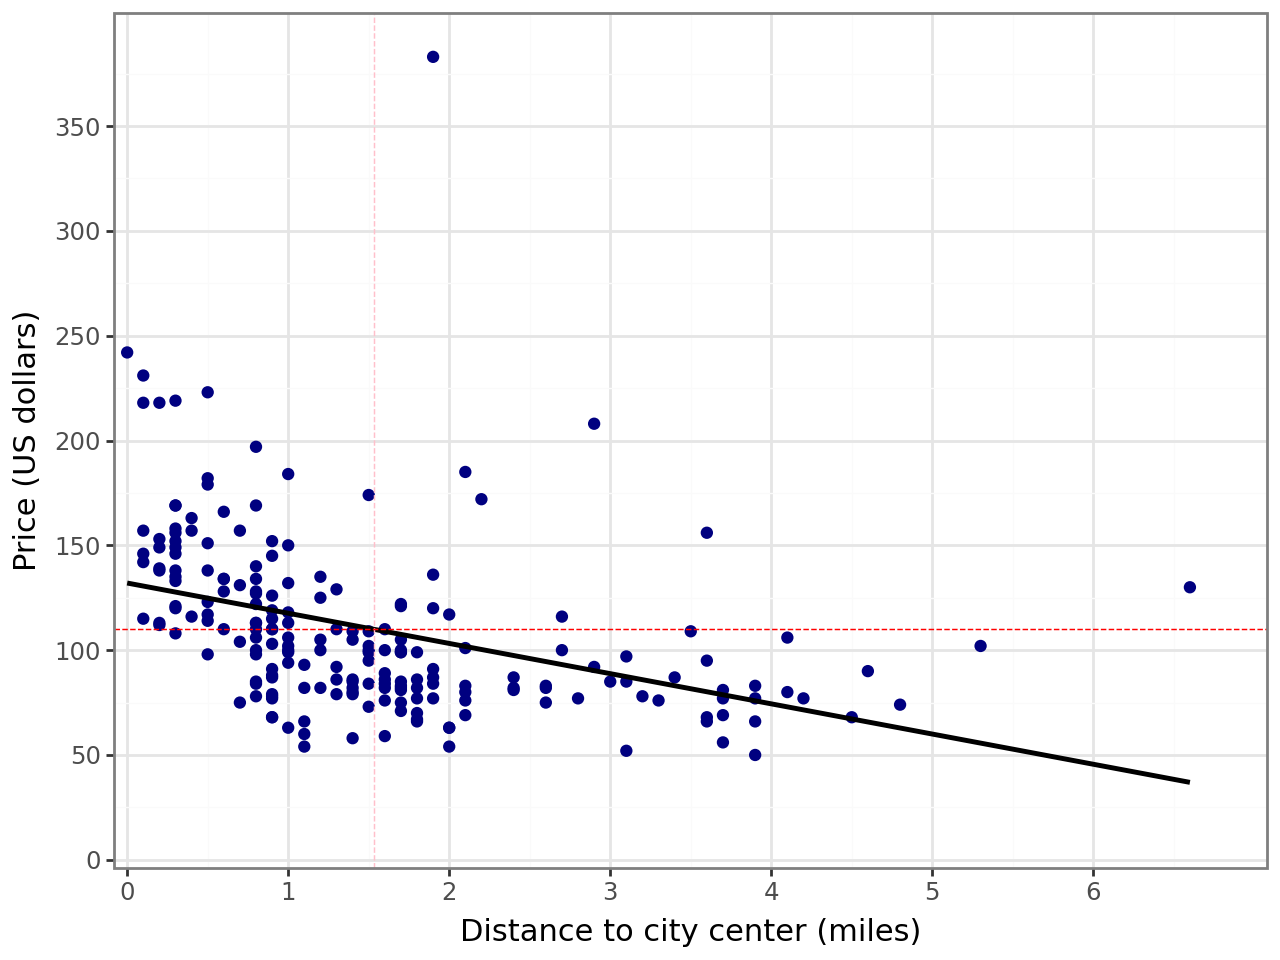

In [36]:
F07_x5 = (
    p1
    + geom_smooth(method="lm", color="black", se=False)
    + geom_vline(
        xintercept=hotels["distance"].mean(),
        color="pink",
        linetype="dashed",
        size=0.3,
    )
    + geom_hline(
        yintercept=hotels["price"].mean(), color="red", linetype="dashed", size=0.3
    )
)
F07_x5.show()


### PREDICTED VALUES & RESIDUALS OF LINEAR REGRESSION 

In [37]:
# OLS for distance & price

regression = smf.ols(formula="price~distance", data=hotels).fit()

hotels["predprice"] = regression.predict()
hotels["e"] = regression.resid

In [38]:
# OLS for rating_count & price

regression_r = smf.ols(formula="price~rating_count", data=hotels).fit()

hotels["predratcount"] = regression.predict()
hotels["e-ratcount"] = regression.resid
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,dist4_s,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e,predratcount,e-ratcount
1,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,1,2,98.855263,2.5,98.855263,1,107.526058,-26.526058,107.526058,-26.526058
2,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,1,2,98.855263,2.5,98.855263,1,111.847984,-26.847984,111.847984,-26.847984
3,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,1,2,98.855263,2.5,98.855263,1,107.526058,-24.526058,107.526058,-24.526058
4,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,1,2,98.855263,2.5,98.855263,1,114.729268,-32.729268,114.729268,-32.729268
6,Austria,Vienna,57.0,City centre,Donauturm,Alsergrund,103,Vienna,4.0,3.5,...,0,1,132.913580,1.5,132.913580,0,119.051194,-16.051194,119.051194,-16.051194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Austria,Vienna,77.0,City centre,Donauturm,Wieden,100,Vienna,3.0,4.0,...,1,2,98.855263,2.5,98.855263,1,114.729268,-14.729268,114.729268,-14.729268
421,Austria,Vienna,572.0,City centre,Donauturm,Wieden,95,Vienna,4.0,4.0,...,1,2,98.855263,2.5,98.855263,1,110.407342,-15.407342,110.407342,-15.407342
422,Austria,Vienna,53.0,City centre,Donauturm,Wieden,73,Vienna,3.0,3.0,...,1,2,98.855263,2.5,98.855263,1,110.407342,-37.407342,110.407342,-37.407342
425,Austria,Vienna,112.0,City centre,Donauturm,Wieden,100,Vienna,4.0,4.5,...,1,2,98.855263,2.5,98.855263,1,117.610552,-17.610552,117.610552,-17.610552


### Figure 7.6, Table 7.1

Pick one observation, with distance = 2.9, and label the residual on the scatter plot

In [39]:
xa = 2.9 # distance

#get annotation values from the dataframe
ya = hotels.loc[hotels["distance"] == xa, "price"].values[0]
ym = hotels.loc[hotels["distance"] == xa, "predprice"].values[0]

xar = 2.9 # distance

#get annotation values from the dataframe
yar = hotels.loc[hotels["distance"] == xar, "rating_count"].values[0]
ymr = hotels.loc[hotels["distance"] == xar, "predratcount"].values[0]

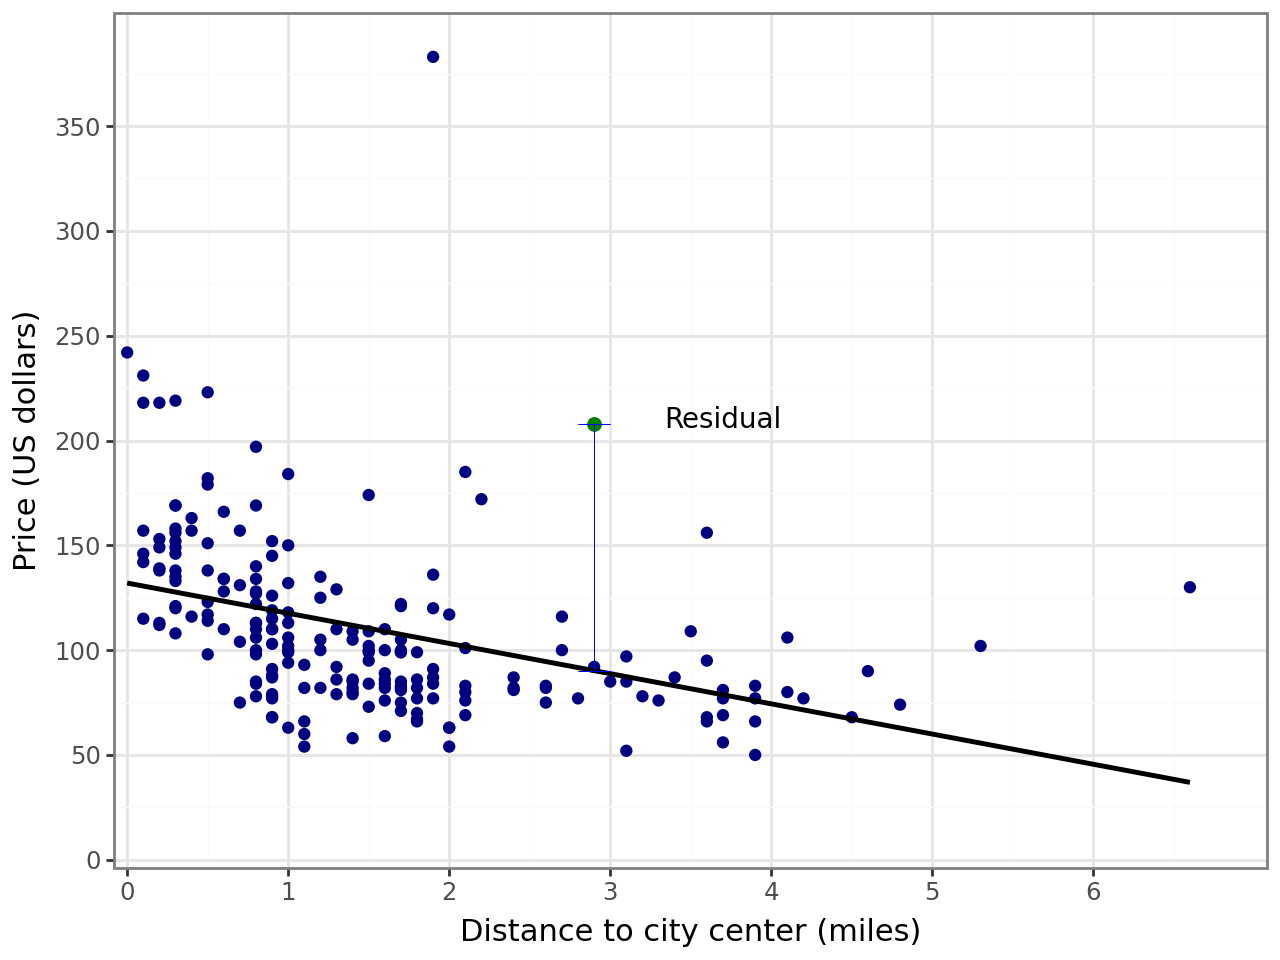

In [40]:
(
    p1
    + geom_smooth(method="lm", color="black", se=False)
    + annotate(
        "text",
        x=3.7,
        y=210,
        label="Residual",
        size=10,
    )
    + annotate("pointrange", x=xa, y=ya, ymin=ya, ymax=ya, color="green", size=0.5)
    + geom_errorbar(
        hotels.loc[hotels["distance"] == xa],
        aes(x="distance", ymin=ym, ymax=ya),
        width=0.2,
        size=0.2,
        color="blue",
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7,1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 400,50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)

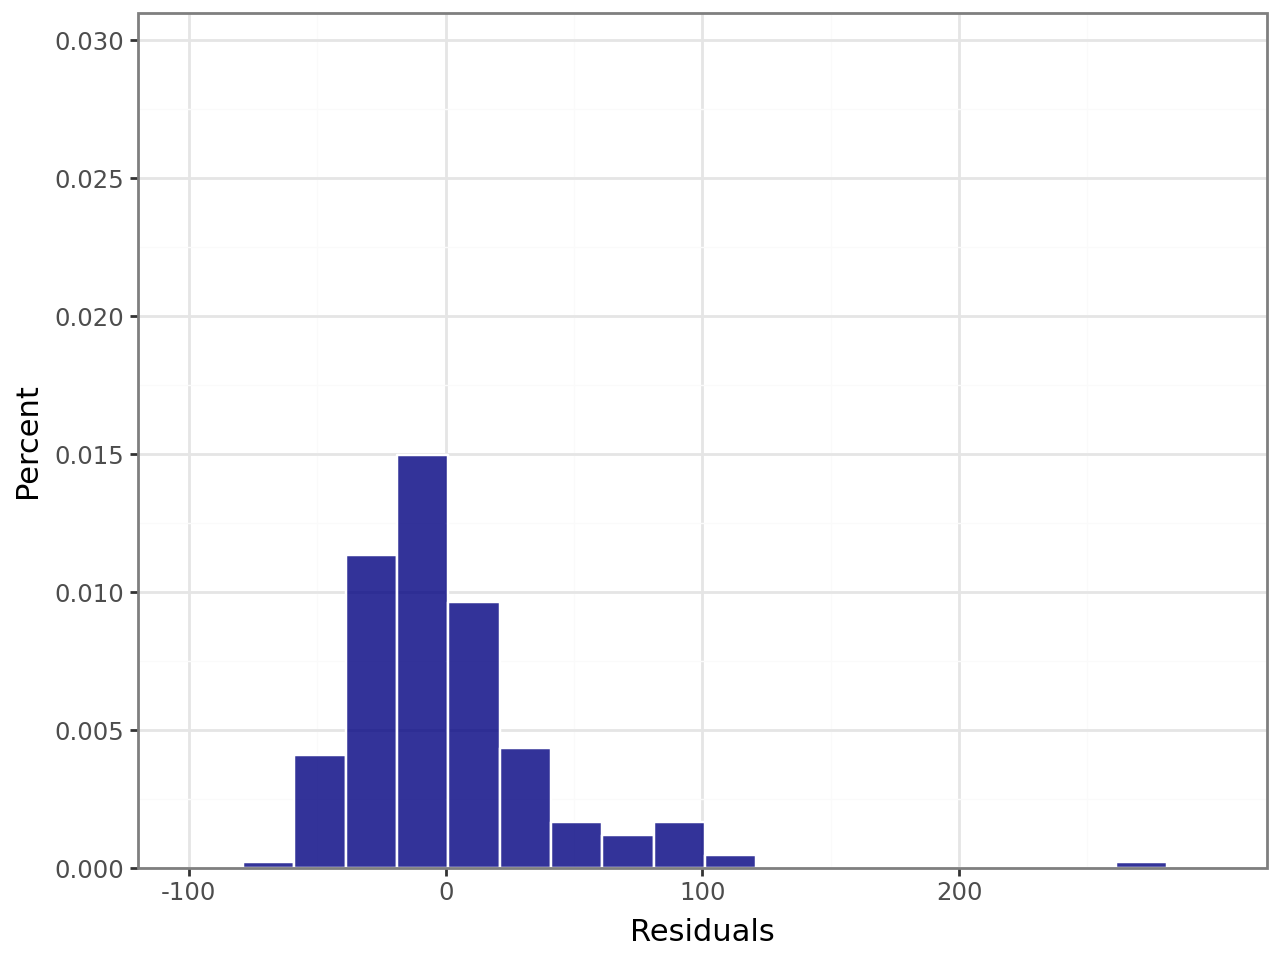

In [41]:
F07_6b = (
    ggplot(hotels, aes(x="e"))
    + geom_histogram(
        aes(y=after_stat('density')),
        binwidth=20,
        boundary=1,
        fill="navy",
        color="white",
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Residuals", y="Percent")
    + scale_x_continuous(limits=(-100, 300), breaks=np.arange(-100, 300, 100))
    + scale_y_continuous(
        expand=(0, 0),
        limits=(0, 0.031),
        breaks=np.arange(0, 0.031, 0.005)
    )
    + theme_bw()
)
F07_6b.show()


In [42]:
hotels["reg1_res"] = ["overpriced" if e >= 0 else "underpriced" for e in hotels["e"]]


In [43]:
hotels.loc[hotels["e"].sort_values().tail().index, "reg1_res"] = "top5"
hotels.loc[hotels["e"].sort_values().head().index, "reg1_res"] = "bottom5"


In [44]:
hotels_top = hotels[hotels["reg1_res"] == "top5"]
hotels_top

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e,predratcount,e-ratcount,reg1_res
26,Austria,Vienna,178.0,City centre,Donauturm,Donaustadt,208,Vienna,4.0,4.0,...,3,97.545455,3.5,97.545455,2,90.238353,117.761647,90.238353,117.761647,top5
110,Austria,Vienna,56.0,City centre,Donauturm,Innere Stadt,231,Vienna,4.0,4.5,...,1,132.913580,1.5,132.913580,0,130.576331,100.423669,130.576331,100.423669,top5
128,Austria,Vienna,404.0,City centre,Donauturm,Innere Stadt,242,Vienna,4.0,4.5,...,1,132.913580,1.5,132.913580,0,132.016973,109.983027,132.016973,109.983027,top5
129,Austria,Vienna,123.0,City centre,Donauturm,Innere Stadt,223,Vienna,4.0,3.5,...,1,132.913580,1.5,132.913580,0,124.813762,98.186238,124.813762,98.186238,top5
247,Austria,Vienna,122.0,City centre,Donauturm,Margareten,383,Vienna,3.0,4.0,...,2,98.855263,2.5,98.855263,1,104.644774,278.355226,104.644774,278.355226,top5


In [45]:
hotels_bottom = hotels[hotels["reg1_res"] == "bottom5"]
hotels_bottom.sort_values(by="e", ascending=True)

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e,predratcount,e-ratcount,reg1_res
153,Austria,Vienna,63.0,City centre,Donauturm,Josefstadt,54,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,116.169910,-62.169910,116.169910,-62.169910,bottom5
10,Austria,Vienna,203.0,City centre,Donauturm,Alsergrund,60,Vienna,4.0,4.0,...,2,98.855263,2.5,98.855263,1,116.169910,-56.169910,116.169910,-56.169910,bottom5
211,Austria,Vienna,242.0,City centre,Donauturm,Leopoldstadt,63,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,117.610552,-54.610552,117.610552,-54.610552,bottom5
426,Austria,Vienna,169.0,City centre,Donauturm,Wieden,58,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,111.847984,-53.847984,111.847984,-53.847984,bottom5
223,Austria,Vienna,84.0,City centre,Donauturm,Leopoldstadt,68,Vienna,3.0,4.0,...,1,132.913580,1.5,132.913580,0,119.051194,-51.051194,119.051194,-51.051194,bottom5


In [46]:
bestdeals = hotels.loc[hotels["e"].sort_values().head().index]
bestdeals

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,xend,yend,dist7_new,Eprice_cat7_new,dist7_s,predprice,e,predratcount,e-ratcount,reg1_res
153,Austria,Vienna,63.0,City centre,Donauturm,Josefstadt,54,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,116.169910,-62.169910,116.169910,-62.169910,bottom5
10,Austria,Vienna,203.0,City centre,Donauturm,Alsergrund,60,Vienna,4.0,4.0,...,2,98.855263,2.5,98.855263,1,116.169910,-56.169910,116.169910,-56.169910,bottom5
211,Austria,Vienna,242.0,City centre,Donauturm,Leopoldstadt,63,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,117.610552,-54.610552,117.610552,-54.610552,bottom5
426,Austria,Vienna,169.0,City centre,Donauturm,Wieden,58,Vienna,3.0,3.0,...,2,98.855263,2.5,98.855263,1,111.847984,-53.847984,111.847984,-53.847984,bottom5
223,Austria,Vienna,84.0,City centre,Donauturm,Leopoldstadt,68,Vienna,3.0,4.0,...,1,132.913580,1.5,132.913580,0,119.051194,-51.051194,119.051194,-51.051194,bottom5


### Figure 7.7
### adding annotation

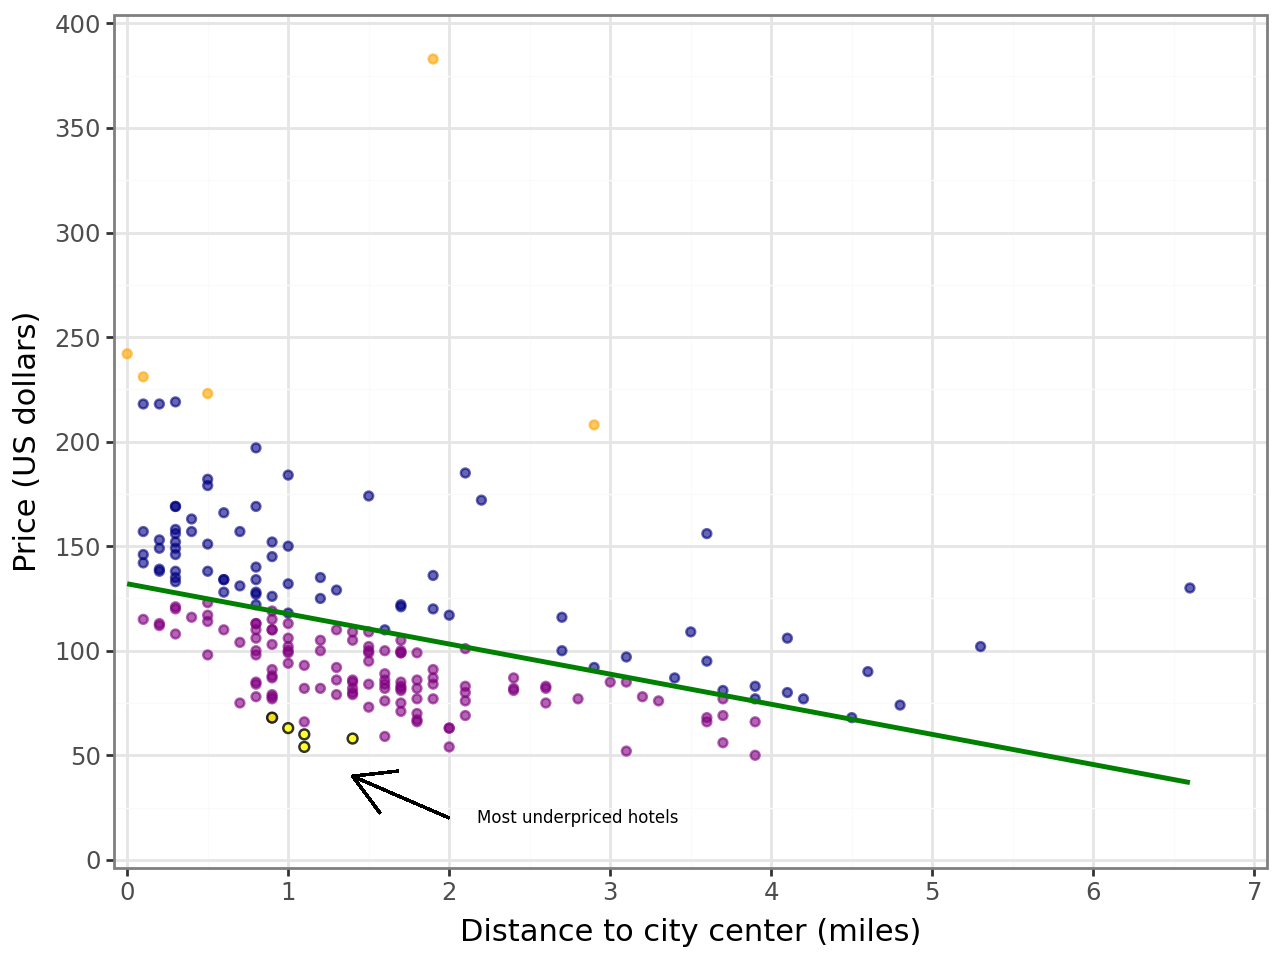

In [47]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "overpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "underpriced"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "bottom5"],
        aes(color="reg1_res", fill="reg1_res"),
        size=1.5,
        alpha=0.8,
        show_legend=False,
    )
    + geom_point(
        hotels.loc[hotels["reg1_res"] == "top5"],
        aes(color="reg1_res"),
        size=1.3,
        alpha=0.6,
        show_legend=False,
    )
    + geom_smooth(method="lm", size=1, color="green", se=False)
    + coord_cartesian(xlim=(0, 7), ylim=(0, 400))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 8), breaks=np.arange(0, 8, 1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=np.arange(0, 401, 50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + scale_color_manual(name="", values=("navy", "purple", "black", "orange"))
    + scale_fill_manual(name="", values="yellow")
    + annotate("text", x=2.8, y=20, label="Most underpriced hotels", size=6)
    + geom_segment(aes(x=2, y=20, xend=1.4, yend=40), arrow=arrow())
    + theme_bw()
)


### Table 7.1

In [48]:
(
    hotels.loc[
        hotels["reg1_res"] == "bottom5",
        ["hotel_id", "distance", "price", "predprice", "e"],
    ]
    .sort_values(by=["e"])
    .round(2)
    .reset_index(drop=True)
    .rename({"e": "residual"}, axis=1)
)

,hotel_id,distance,price,predprice,residual
0,22080,1.1,54,116.17,-62.17
1,21912,1.1,60,116.17,-56.17
2,22152,1.0,63,117.61,-54.61
3,22408,1.4,58,111.85,-53.85
4,22165,0.9,68,119.05,-51.05


In [1]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# x and y are your data arrays
smoothed = lowess(y, x, frac=0.3)  # frac = smoothing parameter

# Plot the result
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red')


NameError: name 'y' is not defined